<a href="https://colab.research.google.com/github/ali-rehman-ML/EdgeSeg/blob/main/notebooks/Efficient_vit_export_onnx_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

# Define the label map
label_map = np.array(
    (
        -1, -1, -1, -1, -1, -1, -1, 0,  # road 7
        1,  # sidewalk 8
        -1, -1, 2,  # building 11
        3,  # wall 12
        4,  # fence 13
        -1, -1, -1, 5,  # pole 17
        -1, 6,  # traffic light 19
        7,  # traffic sign 20
        8,  # vegetation 21
        9,  # terrain 22
        10,  # sky 23
        11,  # person 24
        12,  # rider 25
        13,  # car 26
        14,  # truck 27
        15,  # bus 28
        -1, -1, 16,  # train 31
        17,  # motorcycle 32
        18  # bicycle 33
    )
)

# Function to map the original image values to the new range
def map_image_values(image, label_map):
    mapped_image = np.copy(image)
    for original_value in range(len(label_map)):
        if label_map[original_value] != -1:
            mapped_image[image == original_value] = label_map[original_value]
        else:
            mapped_image[image == original_value] = 0  # Optionally map -1 values to 0
    return mapped_image




In [ ]:
from torchvision.datasets import Cityscapes

dataset = Cityscapes(root='/content/drive/MyDrive/EdgeSeg/cityscapes', split='val', mode='fine', target_type='semantic')


In [ ]:
img, smnt = dataset[80]


[ 0  1  2  5  6  7  8  9 10 11 13 14] (1024, 2048)


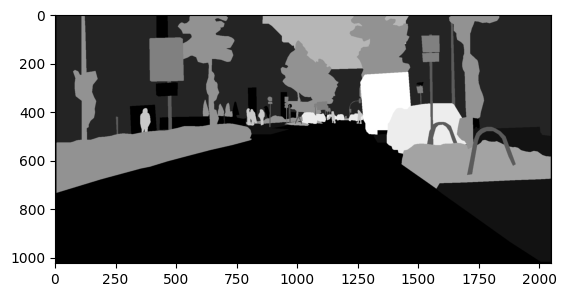

[ 0  1  2  5  6  7  8  9 10 11 13 14] (1024, 2048)


In [ ]:
import cv2
import numpy as np

msk=np.array(smnt)
mapped_image = map_image_values(msk, label_map)
print(np.unique(mapped_image),mapped_image.shape)
import matplotlib.pyplot as plt
plt.imshow(mapped_image,cmap='gray')
plt.show()

print(np.unique(mapped_image),msk.shape)


In [ ]:
import cv2
import numpy as np
import torch
from PIL import Image
import torchvision.transforms.functional as F
from torchvision import transforms

def prepare_input(pil_image, crop_size=512):
    class Resize:
        def __init__(self, crop_size, interpolation=cv2.INTER_CUBIC):
            self.crop_size = crop_size
            self.interpolation = interpolation

        def __call__(self, feed_dict):
            if self.crop_size is None or self.interpolation is None:
                return feed_dict

            image, target = feed_dict["data"], feed_dict["label"]
            height, width = self.crop_size

            h, w, _ = image.shape
            if width != w or height != h:
                image = cv2.resize(
                    image,
                    dsize=(width, height),
                    interpolation=self.interpolation,
                )
            return {
                "data": image,
                "label": target,
            }

    class ToTensor:
        def __init__(self, mean, std, inplace=False):
            self.mean = mean
            self.std = std
            self.inplace = inplace

        def __call__(self, feed_dict):
            image, mask = feed_dict["data"], feed_dict["label"]
            image = image.transpose((2, 0, 1))  # (H, W, C) -> (C, H, W)
            image = torch.as_tensor(image, dtype=torch.float32).div(255.0)
            mask = torch.as_tensor(mask, dtype=torch.int64)
            image = F.normalize(image, self.mean, self.std, self.inplace)
            return {
                "data": image,
                "label": mask,
            }

    image = np.array(pil_image.convert("RGB"))
    transform = transforms.Compose(
        [
            Resize((crop_size, crop_size * 2)),
            ToTensor(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    data = transform({"data": image, "label": np.ones_like(image)})["data"]
    data = torch.unsqueeze(data, dim=0).cpu()
    return data

# Example usage:
# from PIL import Image
tensor = prepare_input(img,crop_size=1024)


In [ ]:
!git clone https://github.com/ali-rehman-ML/efficientvit.git

Cloning into 'efficientvit'...
remote: Enumerating objects: 855, done.
remote: Counting objects: 100% (532/532), done.
remote: Compressing objects: 100% (315/315), done.
remote: Total 855 (delta 302), reused 347 (delta 211), pack-reused 323
Receiving objects: 100% (855/855), 117.06 MiB | 24.90 MiB/s, done.
Resolving deltas: 100% (418/418), done.


In [ ]:
cd /content/efficientvit

/content/efficientvit


In [ ]:
!pip install -r requirements.txt

In [ ]:
from efficientvit.seg_model_zoo import create_seg_model
model = create_seg_model(
  name="b1", dataset="cityscapes", weight_url="/content/drive/MyDrive/EdgeSeg/Model Weights/b1.pt"
)

In [ ]:
!python onnx_export.py --export_path /content/new.onnx --task seg --dataset cityscapes --model b1 --weight_url /content/drive/MyDrive/EdgeSeg/Model\ Weights/b1.pt --bs 1 --resolution 1024

/content/efficientvit/efficientvit/models/nn/ops.py:479: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if H * W > self.dim:
/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pas

In [ ]:
import onnxruntime as onnxrt
import numpy as np

onnx_session= onnxrt.InferenceSession("/content/new.onnx")
onnx_inputs= onnx_session.get_inputs()[0].name



In [ ]:
input=tensor.detach().cpu().numpy()

In [ ]:
import time
t1=time.time()
onnx_output = onnx_session.run(None, {onnx_inputs: input.astype(np.float32)})
t2=time.time()
print(t2-t1)

print(onnx_output[0].shape)

10.953740358352661
(1, 19, 128, 256)


In [ ]:
!python tflite_export.py --export_path /content/efficinetvitb.tflite --task seg --dataset cityscapes --model b1 --weight_url /content/drive/MyDrive/EdgeSeg/Model\ Weights/b1.pt  --resolution 1024

In [ ]:
!pip install tflite_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.4 MB/s eta 0:00:00


In [ ]:
import tflite_runtime.interpreter as tflite
import numpy as np
import time

interpreter = tflite.Interpreter(model_path='/content/efficinetvitb.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)





[{'name': 'x.1', 'index': 7, 'shape': array([   1, 1024, 2048,    3], dtype=int32), 'shape_signature': array([   1, 1024, 2048,    3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': '1541', 'index': 463, 'shape': array([  1, 128, 256,  19], dtype=int32), 'shape_signature': array([  1, 128, 256,  19], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
numpy_array = tensor.permute(0, 2, 3, 1).cpu().numpy().astype(np.float32)
print(numpy_array.shape)



(1, 1024, 2048, 3)


In [ ]:
interpreter.set_tensor(input_details[0]['index'], numpy_array)
start = time.time()
interpreter.invoke()
end = time.time()
print(end - start)
tflite_output = interpreter.get_tensor(output_details[0]['index'])
print(tflite_output.shape)

2.154125213623047
(1, 128, 256, 19)


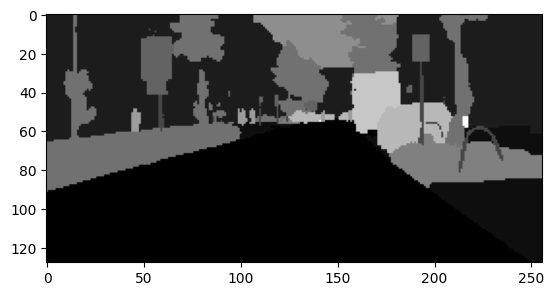

In [ ]:
import matplotlib.pyplot as plt
out=np.argmax(tflite_output,axis=3)
plt.imshow(out[0],cmap='gray')
plt.show()

In [ ]:
import torch.nn.functional as F

def resize(
    x: torch.Tensor,
    size: any or None = None,
    scale_factor: list[float] or None = None,
    mode: str = "bicubic",
    align_corners: bool or None = False,
) -> torch.Tensor:
    if mode in {"bilinear", "bicubic"}:
        return F.interpolate(
            x,
            size=size,
            scale_factor=scale_factor,
            mode=mode,
            align_corners=align_corners,
        )
    elif mode in {"nearest", "area"}:
        return F.interpolate(x, size=size, scale_factor=scale_factor, mode=mode)
    else:
        raise NotImplementedError(f"resize(mode={mode}) not implemented.")

In [ ]:
torch_output = torch.from_numpy(tflite_output)
print(torch_output.shape)
r_o=resize(o,size=(1024,2048))


torch.Size([1, 128, 256, 19])


In [ ]:
output = (torch.argmax(r_o, dim=1).cpu().numpy()[0])

print(np.unique(output),"\n",np.unique(mapped_image))

[ 0  1  2  5  6  7  8  9 10 11 13 14 18] 
 [ 0  1  2  5  6  7  8  9 10 11 13 14]


[ 0  1  2  5  6  7  8  9 10 11 13 14] 
 [ 0  1  2  5  6  7  8  9 10 11 13 14]


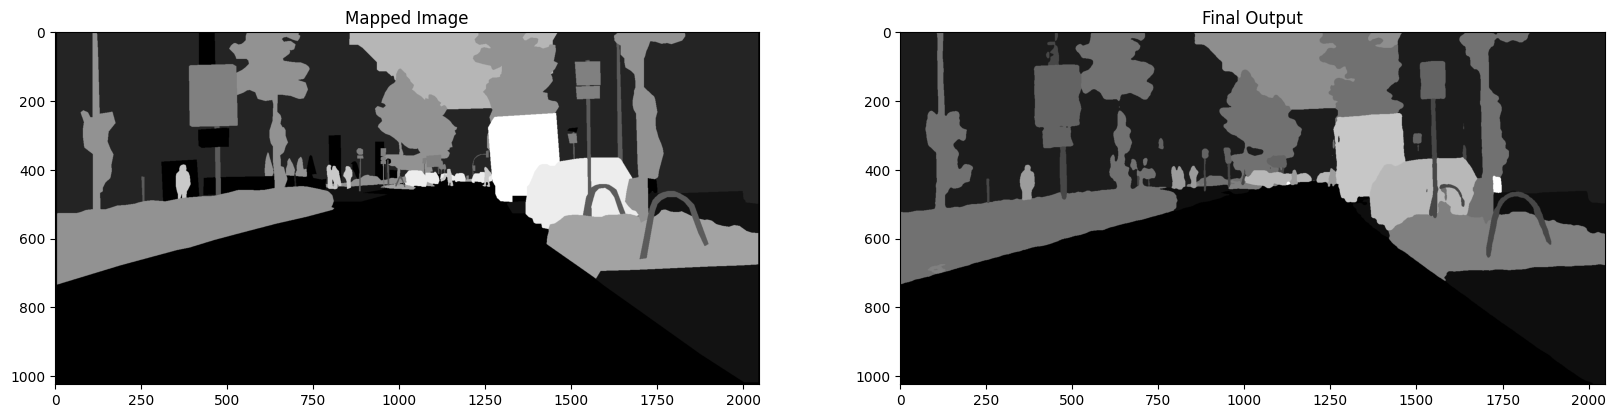

In [ ]:
# prompt: plot mapped image and final_o on same figure make two columsn and big figure size

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns, adjust figsize as needed
print(np.unique(mapped_image),"\n",np.unique(mapped_image))
ax[0].imshow(mapped_image, cmap='gray')
ax[0].set_title('Mapped Image')

ax[1].imshow(output, cmap='gray')
ax[1].set_title('Final Output')

plt.show()


In [ ]:
import numpy as np

def calculate_iou_and_miou(ground_truth, prediction, num_classes):
    """
    Calculate the IoU for each class and the mIoU for a single image.

    Parameters:
    - ground_truth: 2D numpy array, ground truth mask
    - prediction: 2D numpy array, predicted mask
    - num_classes: int, number of classes

    Returns:
    - class_iou: dictionary, IoU for each class
    - miou: float, mean IoU across all classes
    """
    class_iou = {}
    ious = []

    for c in range(num_classes):
        # Create binary masks for the class
        gt_class = (ground_truth == c)
        pred_class = (prediction == c)

        # Calculate intersection and union
        intersection = np.logical_and(gt_class, pred_class).sum()
        union = np.logical_or(gt_class, pred_class).sum()

        if union == 0:
            # Handle case where class is not present in both ground truth and prediction
            iou = float('nan')
        else:
            iou = intersection / union

        class_iou[c] = iou
        if not np.isnan(iou):
            ious.append(iou)

    # Calculate mean IoU, ignoring classes with NaN IoU
    miou = np.nanmean(ious) if ious else float('nan')

    return class_iou, miou


num_classes = 19

class_iou, miou = calculate_iou_and_miou(mapped_image, output, num_classes)
print("Class IoU:", class_iou)
print("Mean IoU:", miou)


Class IoU: {0: 0.9197222910157739, 1: 0.9130268433779193, 2: 0.8851946652296915, 3: nan, 4: nan, 5: 0.5230994687671735, 6: 0.013986013986013986, 7: 0.8014401608491338, 8: 0.9023258021644199, 9: 0.9105564574314574, 10: 0.9360130020616695, 11: 0.7868435599778884, 12: nan, 13: 0.8607007414954435, 14: 0.9670368323199839, 15: nan, 16: nan, 17: nan, 18: 0.0}
Mean IoU: 0.7246112183597361
